# 1.import libraries

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as v_utils
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import os

# 2. data load

5


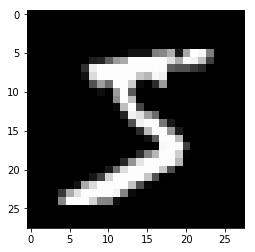

In [2]:
# mnist data 다운로드
mnist_train = dset.MNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)

# mnist data tensor로 생성
mnist_data = np.array([tensor for tensor in mnist_train])

# tensor로 생성된 mnist데이터를 numpy로 바꾸기
mnist_image = np.array([tensor.numpy() for tensor in mnist_data[:,0]]).reshape(-1,28*28)
mnist_label = mnist_data[:,1]

# 결과확인하기
print(mnist_label[0])
plt.imshow(mnist_image[0].reshape(28,28),cmap='gray')
plt.show()

# 3. model

In [3]:
# Generator receives random noise z and create 784
class generator(nn.Module):
    def __init__(self,input_size=100,
                 hidden1_size = 512,hidden2_size=512,output_size=784):
        super(generator,self).__init__()
        
        self.input_size = input_size
        self.hidden1_size = hidden1_size
        self.hidden2_size = hidden2_size
        self.output_size = output_size
        
        # define model
        self.layer1 = nn.Linear(input_size,hidden1_size)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(hidden1_size,hidden2_size)
        self.relu2 = nn.ReLU()
        self.layer3 = nn.Linear(hidden2_size,output_size)
        
    def forward(self,z):
        out = self.layer1(z)
        out = self.relu1(out)
        out = self.layer2(out)
        out = self.relu2(out)
        out = self.layer3(out)
        return out

In [4]:
# Discriminator return fake or real

class discriminator(nn.Module):
    def __init__(self,input_size = 784,
                hidden1_size =512, hidden2_size=256):
        super(discriminator,self).__init__()
        
        self.input_size = input_size
        self.hidden1_size = hidden1_size
        self.hidden2_size = hidden2_size
        
        # define model
        self.layer1 = nn.Linear(input_size,hidden1_size)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(hidden1_size,hidden2_size)
        self.relu2 = nn.ReLU()
        self.layer3 = nn.Linear(hidden2_size,1)
        self.sigm = nn.Sigmoid()
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.relu1(out)
        out = self.layer2(out)
        out = self.relu2(out)
        out = self.layer3(out)
        out = self.sigm(out)
        return out

In [9]:
# GAN
class GAN(object):
    def __init__(self,input_size=784,z_size=100,
                g_h1 = 512, g_h2 = 512, d_h1 = 512, d_h2 = 256):
    
        self.input_size = input_size
        self.z_size = z_size
        self.g_h1 = g_h1
        self.g_h2 = g_h2
        self.d_h1 = d_h1
        self.d_h2 = d_h2
        
        self.G = None
        self.D = None
        self.G_optim = None
        self.D_optim = None
        
        self.build_model()
    
    def build_model(self):
        self.G = generator(self.z_size,self.g_h1,
                          self.g_h2,self.input_size)
        self.D = discriminator(self.input_size,self.d_h1,self.d_h2)
        
        G_optim = torch.optim.Adam(self.G.parameters(), lr=lr)
        D_optim = torch.optim.Adam(self.D.parameters(), lr=lr)
        
    def train(self,data,fixed_z,batch_size=32,epoch=10,
             lr=0.01):
        
        # BCELoss -> loss(o,t) = -1/n_sum(t_i*log(o_i)+(1-t_i)*log(1-o_i))
        loss_func = nn.BCELoss()
        

        
        data = Variable(torch.from_numpy(data))
        
        counter = 0
        
        if not os.path.isdir("./gan_result"):
            os.mkdir("./gan_result")
        
        for e in range(epoch):
            for i in range(int(len(data)/batch_size)):
                # update G
                
                z = Variable(torch.randn(batch_size,self.z_size))
                G_optim.zero_grad()
                
                G_fake = self.G.forward(z)
                D_fake = self.D.forward(G_fake)
                
                G_loss = torch.sum(loss_func(D_fake,Variable(torch.ones(batch_size,1))))
                G_loss.backward(retain_variables=True)
                G_optim.step()
                
                # update D
                D_optim.zero_grad()
                D_real = self.D.forward(data[i*batch_size:(i+1)*batch_size])
                
                D_loss = torch.sum(loss_func(D_fake,Variable(torch.zeros(batch_size,1))))+ torch.sum(loss_func(D_real,Variable(torch.ones(batch_size,1))))
                D_loss.backward()
                D_optim.step()
                counter+=1

                if counter %100 ==0:
                    print("{}th iteration G_loss : {} D_loss : {}".format(counter,G_loss.data,D_loss.data))          
                    self.dat = self.G.forward(fixed_z).view(-1,28,28)
                    #v_utils.save_image(self.G.forward(fixed_z).view(-1,28,28).data,"./gan_result/gen_{}.png".format(counter),nrow=5)
 


# 4. train

In [10]:
fixed_z = Variable(torch.randn(20,100))

In [11]:
gan = GAN()

In [16]:
gan.train(data = mnist_image, fixed_z = fixed_z,batch_size=128,lr=0.0002,epoch=100)

C:\ProgramData\Anaconda3\lib\site-packages\torch\autograd\__init__.py:92: UserWarning: retain_variables option is deprecated and will be removed in 0.3. Use retain_graph instead.
  warnings.warn("retain_variables option is deprecated and will be removed in 0.3. "


100th iteration G_loss : 
 6.5187
[torch.FloatTensor of size 1]
 D_loss : 
1.00000e-02 *
  8.5033
[torch.FloatTensor of size 1]

200th iteration G_loss : 
 7.1661
[torch.FloatTensor of size 1]
 D_loss : 
1.00000e-02 *
  4.6120
[torch.FloatTensor of size 1]

300th iteration G_loss : 
 6.0492
[torch.FloatTensor of size 1]
 D_loss : 
1.00000e-02 *
  7.4937
[torch.FloatTensor of size 1]

400th iteration G_loss : 
 6.4368
[torch.FloatTensor of size 1]
 D_loss : 
1.00000e-02 *
  6.7398
[torch.FloatTensor of size 1]

500th iteration G_loss : 
 5.4991
[torch.FloatTensor of size 1]
 D_loss : 
 0.1188
[torch.FloatTensor of size 1]

600th iteration G_loss : 
 5.5242
[torch.FloatTensor of size 1]
 D_loss : 
 0.1048
[torch.FloatTensor of size 1]

700th iteration G_loss : 
 5.3436
[torch.FloatTensor of size 1]
 D_loss : 
 0.1571
[torch.FloatTensor of size 1]

800th iteration G_loss : 
 5.8671
[torch.FloatTensor of size 1]
 D_loss : 
 0.1635
[torch.FloatTensor of size 1]

900th iteration G_loss : 
 5

6900th iteration G_loss : 
 6.2579
[torch.FloatTensor of size 1]
 D_loss : 
 0.2399
[torch.FloatTensor of size 1]

7000th iteration G_loss : 
 5.4638
[torch.FloatTensor of size 1]
 D_loss : 
 0.1050
[torch.FloatTensor of size 1]

7100th iteration G_loss : 
 4.9518
[torch.FloatTensor of size 1]
 D_loss : 
 0.1310
[torch.FloatTensor of size 1]

7200th iteration G_loss : 
 5.0526
[torch.FloatTensor of size 1]
 D_loss : 
1.00000e-02 *
  7.0876
[torch.FloatTensor of size 1]

7300th iteration G_loss : 
 5.3170
[torch.FloatTensor of size 1]
 D_loss : 
 0.1313
[torch.FloatTensor of size 1]

7400th iteration G_loss : 
 5.1315
[torch.FloatTensor of size 1]
 D_loss : 
 0.1230
[torch.FloatTensor of size 1]

7500th iteration G_loss : 
 4.4326
[torch.FloatTensor of size 1]
 D_loss : 
 0.1054
[torch.FloatTensor of size 1]

7600th iteration G_loss : 
 6.0740
[torch.FloatTensor of size 1]
 D_loss : 
 0.1893
[torch.FloatTensor of size 1]

7700th iteration G_loss : 
 4.8434
[torch.FloatTensor of size 1]


13900th iteration G_loss : 
 4.9069
[torch.FloatTensor of size 1]
 D_loss : 
 0.1385
[torch.FloatTensor of size 1]

14000th iteration G_loss : 
 4.3322
[torch.FloatTensor of size 1]
 D_loss : 
 0.2792
[torch.FloatTensor of size 1]

14100th iteration G_loss : 
 4.4620
[torch.FloatTensor of size 1]
 D_loss : 
 0.2237
[torch.FloatTensor of size 1]

14200th iteration G_loss : 
 8.2564
[torch.FloatTensor of size 1]
 D_loss : 
 0.1533
[torch.FloatTensor of size 1]

14300th iteration G_loss : 
 5.8549
[torch.FloatTensor of size 1]
 D_loss : 
 0.1568
[torch.FloatTensor of size 1]

14400th iteration G_loss : 
 4.8011
[torch.FloatTensor of size 1]
 D_loss : 
 0.1294
[torch.FloatTensor of size 1]

14500th iteration G_loss : 
 4.0079
[torch.FloatTensor of size 1]
 D_loss : 
 0.2340
[torch.FloatTensor of size 1]

14600th iteration G_loss : 
 4.5576
[torch.FloatTensor of size 1]
 D_loss : 
1.00000e-02 *
  8.6968
[torch.FloatTensor of size 1]

14700th iteration G_loss : 
 5.0323
[torch.FloatTensor of

21000th iteration G_loss : 
 4.1871
[torch.FloatTensor of size 1]
 D_loss : 
 0.1365
[torch.FloatTensor of size 1]

21100th iteration G_loss : 
 5.2919
[torch.FloatTensor of size 1]
 D_loss : 
 0.2649
[torch.FloatTensor of size 1]

21200th iteration G_loss : 
 4.3609
[torch.FloatTensor of size 1]
 D_loss : 
 0.1368
[torch.FloatTensor of size 1]

21300th iteration G_loss : 
 4.9183
[torch.FloatTensor of size 1]
 D_loss : 
1.00000e-02 *
  6.3900
[torch.FloatTensor of size 1]

21400th iteration G_loss : 
 4.4930
[torch.FloatTensor of size 1]
 D_loss : 
 0.1024
[torch.FloatTensor of size 1]

21500th iteration G_loss : 
 5.2586
[torch.FloatTensor of size 1]
 D_loss : 
1.00000e-02 *
  9.0379
[torch.FloatTensor of size 1]

21600th iteration G_loss : 
 4.4889
[torch.FloatTensor of size 1]
 D_loss : 
 0.1825
[torch.FloatTensor of size 1]

21700th iteration G_loss : 
 6.1523
[torch.FloatTensor of size 1]
 D_loss : 
 0.2985
[torch.FloatTensor of size 1]

21800th iteration G_loss : 
 5.3902
[torch

28000th iteration G_loss : 
 4.2661
[torch.FloatTensor of size 1]
 D_loss : 
1.00000e-02 *
  9.2903
[torch.FloatTensor of size 1]

28100th iteration G_loss : 
 4.3918
[torch.FloatTensor of size 1]
 D_loss : 
 0.1005
[torch.FloatTensor of size 1]

28200th iteration G_loss : 
 4.7352
[torch.FloatTensor of size 1]
 D_loss : 
 0.1135
[torch.FloatTensor of size 1]

28300th iteration G_loss : 
 4.7047
[torch.FloatTensor of size 1]
 D_loss : 
 0.1676
[torch.FloatTensor of size 1]

28400th iteration G_loss : 
 4.6640
[torch.FloatTensor of size 1]
 D_loss : 
 0.1472
[torch.FloatTensor of size 1]

28500th iteration G_loss : 
 4.0470
[torch.FloatTensor of size 1]
 D_loss : 
 0.1880
[torch.FloatTensor of size 1]

28600th iteration G_loss : 
 3.5312
[torch.FloatTensor of size 1]
 D_loss : 
 0.1843
[torch.FloatTensor of size 1]

28700th iteration G_loss : 
 5.4518
[torch.FloatTensor of size 1]
 D_loss : 
 0.5249
[torch.FloatTensor of size 1]

28800th iteration G_loss : 
 4.8859
[torch.FloatTensor of

35100th iteration G_loss : 
 3.4654
[torch.FloatTensor of size 1]
 D_loss : 
 0.3620
[torch.FloatTensor of size 1]

35200th iteration G_loss : 
 4.5494
[torch.FloatTensor of size 1]
 D_loss : 
 0.1970
[torch.FloatTensor of size 1]

35300th iteration G_loss : 
 4.0973
[torch.FloatTensor of size 1]
 D_loss : 
 0.2080
[torch.FloatTensor of size 1]

35400th iteration G_loss : 
 4.2747
[torch.FloatTensor of size 1]
 D_loss : 
 0.1593
[torch.FloatTensor of size 1]

35500th iteration G_loss : 
 4.5238
[torch.FloatTensor of size 1]
 D_loss : 
 0.1748
[torch.FloatTensor of size 1]

35600th iteration G_loss : 
 4.0404
[torch.FloatTensor of size 1]
 D_loss : 
 0.1495
[torch.FloatTensor of size 1]

35700th iteration G_loss : 
 4.8121
[torch.FloatTensor of size 1]
 D_loss : 
 0.1545
[torch.FloatTensor of size 1]

35800th iteration G_loss : 
 4.4784
[torch.FloatTensor of size 1]
 D_loss : 
 0.1065
[torch.FloatTensor of size 1]

35900th iteration G_loss : 
 3.8172
[torch.FloatTensor of size 1]
 D_los

42200th iteration G_loss : 
 4.0289
[torch.FloatTensor of size 1]
 D_loss : 
 0.2767
[torch.FloatTensor of size 1]

42300th iteration G_loss : 
 4.3655
[torch.FloatTensor of size 1]
 D_loss : 
 0.1684
[torch.FloatTensor of size 1]

42400th iteration G_loss : 
 3.9703
[torch.FloatTensor of size 1]
 D_loss : 
 0.2648
[torch.FloatTensor of size 1]

42500th iteration G_loss : 
 4.9002
[torch.FloatTensor of size 1]
 D_loss : 
 0.1736
[torch.FloatTensor of size 1]

42600th iteration G_loss : 
 3.8926
[torch.FloatTensor of size 1]
 D_loss : 
 0.2546
[torch.FloatTensor of size 1]

42700th iteration G_loss : 
 4.9499
[torch.FloatTensor of size 1]
 D_loss : 
 0.2803
[torch.FloatTensor of size 1]

42800th iteration G_loss : 
 3.9094
[torch.FloatTensor of size 1]
 D_loss : 
 0.2074
[torch.FloatTensor of size 1]

42900th iteration G_loss : 
 4.2637
[torch.FloatTensor of size 1]
 D_loss : 
 0.1503
[torch.FloatTensor of size 1]

43000th iteration G_loss : 
 4.0714
[torch.FloatTensor of size 1]
 D_los

KeyboardInterrupt: 

# 5. result

In [17]:
a = gan.G.forward(fixed_z)[0].data.numpy()

In [18]:
plt.imshow(a.reshape(28,28),cmap='gray')

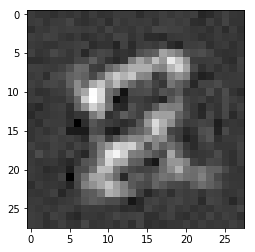

In [19]:
plt.show()